<a href="https://colab.research.google.com/github/rainmaker29/autoencoder-img-res/blob/master/img_res_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,Dropout,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D,add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Encoder

In [0]:
input_img = Input(shape=(256,256,3))

l1 = Conv2D(64,(3,3),padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64,(3,3),padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3= MaxPooling2D(padding='same')(l2)
l4 = Dropout(0.3)(l3)
l5 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l5)
l7 = MaxPooling2D(padding='same')(l6)
l8 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l7)
encoder= Model(input_img,l8)            

In [117]:
encoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 128, 128, 128)     147

# Decoder


In [0]:

input_img = Input(shape=(256, 256, 3))
l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)

l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

decoder = Conv2D(3,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l15)



# Autoencoder

In [0]:
autoencoder = Model(input_img,decoder)
#fenn
autoencoder_hfenn = Model(input_img,decoder)

In [120]:
autoencoder.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 256, 256, 64) 1792        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_61[0][0]                  
___________________________________________________________________________________________

In [0]:
autoencoder.compile(optimizer='adadelta',loss='mean_squared_error')


# Training

In [0]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np

def train_batches(just_load_dataset=False):

  batches=256

  batch=0

  batch_nb=0

  max_batches=-1

  images=[]
  x_train_n=[]
  x_train_down=[]

  x_train_n2 = []
  x_train_down2 = []


  for root,dirnames,filenames in os.walk("/content/drive/My Drive/image_resolution/"):
    for filename in filenames:
      if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
        if batch_nb==max_batches:
          return x_train_n2,x_train_down2
        filepath = os.path.join(root,filename)
        image = pyplot.imread(filepath)
        if len(image.shape)>2:
          image_resized = resize(image,(256,256))
          x_train_n.append(image_resized)
          dwn1 = rescale(image_resized, 2)
          x_train_down.append(rescale(dwn1,0.5)) 
          batch+=1

          if batch == batches:
            batch_nb+=1

            x_train_n2 = np.array(x_train_n)
            x_train_down2 = np.array(x_train_down)

            if just_load_dataset:
              return x_train_n2,x_train_down2

            print("Training batch",batch_nb,'(',batches,')')

            autoencoder.fit(x_train_down2,x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
            
            x_train_n=[]
            x_train_down=[]
            batch=0
  return x_train_n2,x_train_down2

# Loading dataset

In [0]:
x_train_n, x_train_down = train_batches(just_load_dataset=True)

In [144]:
# new_xtrain_down=[]
# for x1 in x_train_down:
#   new_xtrain_down.append(resize(x1,(256,256,3)))
x_train_down[0].shape

(256, 256, 3)

In [0]:
autoencoder.load_weights("/content/drive/My Drive/img_res/sr.img_net.mse_hfenn.final_model5_2.no_patch.weights.best.hdf5")

# Predictions

In [0]:
encoder.load_weights('/content/drive/My Drive/img_res/encoder_weights.hdf5')

In [0]:
encoded_imgs = encoder.predict(x_train_down)

In [149]:
encoded_imgs.shape

(256, 64, 64, 256)

In [0]:
# We clip the output so that it doesn't produce weird colors
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

In [0]:
image_index = 251

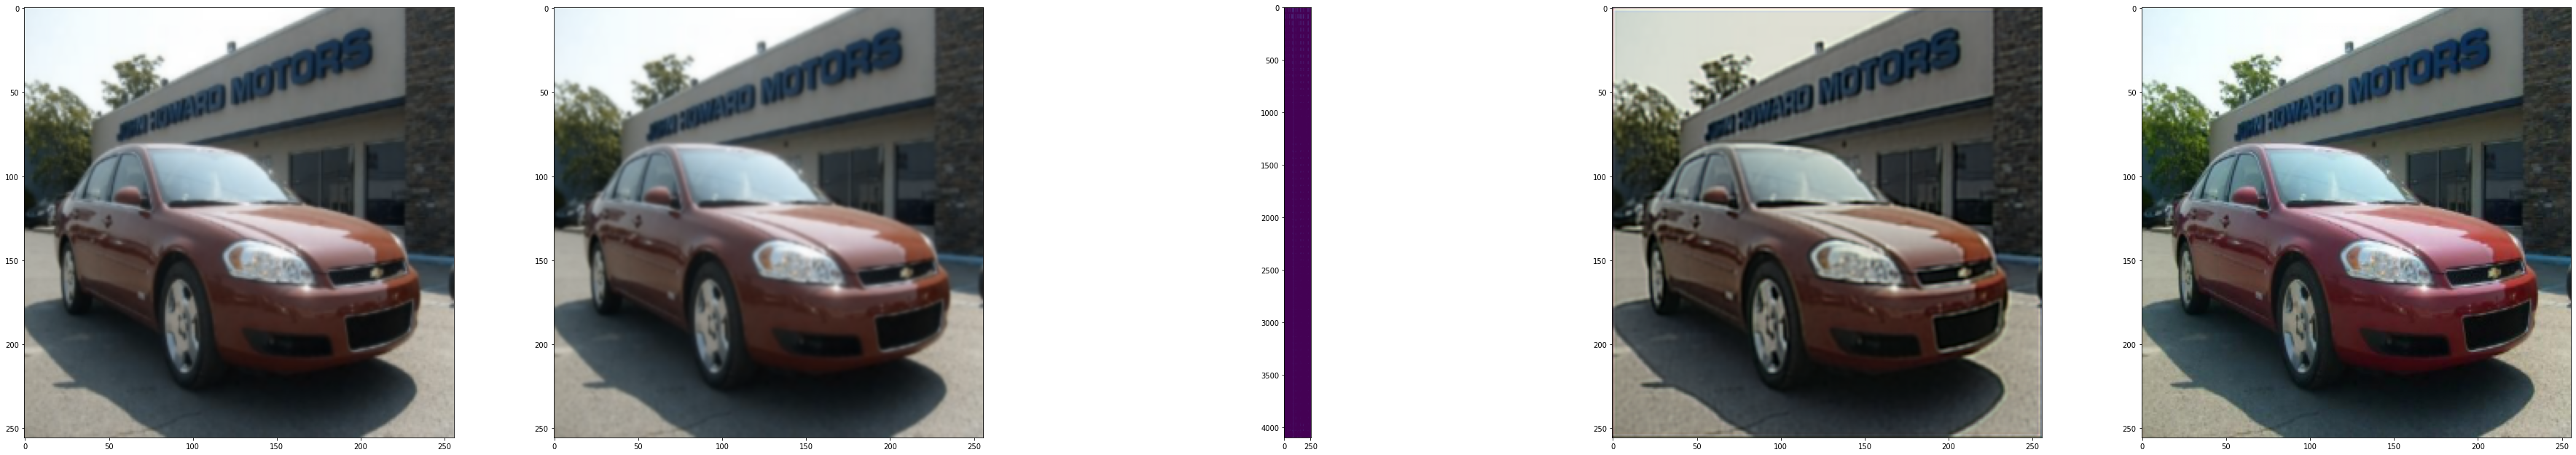

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64, 256)))
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()